In [1]:
# import all required libraries
import sys, os
import numpy as np
import pandas as pd
import random
from random import shuffle, choice
import time
import os
import glob
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from random import shuffle, choice
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# define a function to build MLP for the trait data.    
def create_mlp(traitstrain, regularizer=None):
  model = Sequential()
  # first layer, remember to remove bias if you are intercalating with batch normalization. ReLu is the activation (nonlinear) function.
  model.add(Dense(150, use_bias=False, input_dim=traitstrain.shape[1], activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  # batch normalization.
  model.add(BatchNormalization())
  # second layer.
  model.add(Dense(150, use_bias=False, activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  model.add(BatchNormalization())
  # third layer.
  model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  return model

# define a function to build a CNN for the SNP data. 
def create_cnn(xtest, regularizer=None):
  # obtain the input dimensions.
  inputShape = (xtest.shape[1], xtest.shape[2])
  inputs = Input(shape=inputShape)
  x = inputs
  # first convolutional layer, remember to remove bias if you are intercalating with batch normalization.
  x = Conv1D(250, kernel_size=3, activation='relu', use_bias=False, input_shape=(xtest.shape[1], xtest.shape[2]))(x)
  # batch normalization.
  x = BatchNormalization()(x)
  # second layer.
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  # third layer.
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  # pool the CNN outputs.
  x = MaxPooling1D(pool_size=3)(x)
  # flatten in a single vector.
  x = Flatten()(x)
  # this part is similar to the MLP, a fully connected neural network. We intercalated with dropout to reduce overfitting.
  x = Dense(125, activation='relu')(x)
  # dropout.
  x = Dropout(0.5)(x)
  # second layer of the fully connected neural network.
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  # third layer of the fully connected neural network. This one matches the number of nodes coming out of the MLP.
  x = Dense(50, kernel_regularizer=regularizer)(x)
  x = Activation("relu")(x)
  # Construct the CNN
  model = Model(inputs, x)
  # Return the CNN
  return model

# define a function to combine the outputs of the MLP and the CNN.
# this was obtained from: https://towardsdatascience.com/neural-networks-ensemble-33f33bea7df3
class LinearW(Layer):
    def __init__(self):
        super(LinearW, self).__init__()    
    def build(self, input_shape):
        self.W = self.add_weight(name='name',
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
    def call(self, inputs):
        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim
        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

In [31]:
## define variables that will be used to train all networks.
# size of the minibatches containing simulations are passed through the network in each epoch.
batch_size = 250
# number of training iterations (epochs) for the SNP only and the combined networks.
epochs = 100
# number of training iterations (epochs) for the traits only networks.
epochs_traits = 500
# number of scenarios being classified.
num_classes = 3

# load the traits simulated under the BM model for the 3 scenarios. 
traits_BM = []
traits_BM = np.loadtxt("./traits/traits_BM.txt").reshape(30000,-1,100)
# transform into a NumPy array. 
traits_BM = np.array(traits_BM)

# standard scale the continuous (BM) traits
scalers_BM = {}
for i in range(traits_BM.shape[2]):
    scalers_BM[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers_BM[i].fit_transform(traits_BM[:, :, i]) 

# load the SNPs simulated for the 3 scenarios. 
u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

# transform SNP major alleles in -1 and minor in 1.
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1

# create a label vector in the same order as the simulations.
y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

# make sure labels, SNP and traits matrices all have the same length.
print (len(y), len(X), len(traits_BM))

30000 30000 30000


In [3]:
################################################################################################################################################
# We will start with traits simulated under the BM model.
################################################################################################################################################

# Since we will run the analysis on several subsets, define a function for training on each data subsets (Combined datasets, SNP only and BM traits only).

# function to train on the combined datasets
def combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test):
    # convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
    ytest = np_utils.to_categorical(ytest, num_classes)
    ytrain = np_utils.to_categorical(ytrain, num_classes)
    # reshape the traits matrices to input them into the MLP
    traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
    traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
    # Create the MLP, the CNN and the combined models
    mlp = create_mlp(traits_BM_train)
    cnn = create_cnn(xtest)
    combinedInput = LinearW()([mlp.output, cnn.output])

    # The final fully-connected layer head will have two dense layers (one relu and one softmax)
    x = Dense(50, activation="relu")(combinedInput)
    x = Dense(num_classes, activation="softmax")(x)

    # The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)

    # using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
    opt = SGD(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

    print(model.summary())
    # save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)

    # fit the model and record running times
    start = time.time()
    model.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
    print (f'Time: {time.time() - start}')
    
    return model

# function to train on the SNP only datasets
def SNP_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test):
    # convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
    ytest = np_utils.to_categorical(ytest, num_classes)
    ytrain = np_utils.to_categorical(ytrain, num_classes)
    # reshape the traits matrices to input them into the MLP
    traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
    traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
    # Create the MLP, the CNN and the combined models
    mlp = create_mlp(traits_BM_train)
    cnn = create_cnn(xtest)
    combinedInput = LinearW()([mlp.output, cnn.output])
    
    #Create the last layer for the SNP network
    xCNN = Dense(num_classes, activation="softmax")(cnn.output)
    model = Model(inputs=cnn.input, outputs=xCNN)

    # using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
    opt = SGD(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

    print(model.summary())

    # save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)

    # fit the model and record running times
    start = time.time()
    model.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
    print (f'Time: {time.time() - start}')
    
    return model

# function to train on the BM trait only datasets
def BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test):
    # convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
    ytest = np_utils.to_categorical(ytest, num_classes)
    ytrain = np_utils.to_categorical(ytrain, num_classes)
    # reshape the traits matrices to input them into the MLP
    traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
    traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
    mlp = create_mlp(traits_BM_train)
    #Create the last layer for the traits network
    xMLP = Dense(num_classes, activation="softmax")(mlp.output)
    model = Model(inputs=mlp.input, outputs=xMLP)

    # using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
    opt = SGD(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

    print(model.summary())

    # save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
    # fit the model and record running times
    start = time.time()
    model.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
    print (f'Time: {time.time() - start}')
    
    return model

In [4]:
################################################################################################################################################
#Combined 100 BM, 1K SNPs
################################################################################################################################################

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X,traits_BM,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 998, 250)     45000       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 998, 250)    1000        ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_2[0][

2023-08-01 16:11:12.274724: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod/assets


In [5]:
################################################################################################################################################
#1K SNPs only
################################################################################################################################################
# now repeat the analysis only for SNPs
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X,traits_BM,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = SNP_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_CNN_Model_1KSNPs.acc.mod')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 998, 250)          45000     
                                                                 
 batch_normalization_7 (Batc  (None, 998, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 996, 250)          187500    
                                                                 
 batch_normalization_8 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 994, 250)          1875

In [6]:
################################################################################################################################################
#100 BM
################################################################################################################################################
# now repeat the analysis only for traits
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X,traits_BM,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Traits_Model_100BM.acc.mod')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_15 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_10 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_11 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 50)                7550

In [7]:
################################################################################################################################################
#100 BM, 50 SNPs
################################################################################################################################################
# subset the SNPs
X50=X[:,0:50,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X50,traits_BM,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 48, 250)      45000       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 48, 250)     1000        ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 46, 250)      187500      ['batch_normalization_14[0]

In [8]:
################################################################################################################################################
#50 SNPs
################################################################################################################################################
# now repeat the analysis only for SNPs
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X50,traits_BM,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = SNP_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 60)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 48, 250)           45000     
                                                                 
 batch_normalization_19 (Bat  (None, 48, 250)          1000      
 chNormalization)                                                
                                                                 
 conv1d_10 (Conv1D)          (None, 46, 250)           187500    
                                                                 
 batch_normalization_20 (Bat  (None, 46, 250)          1000      
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 44, 250)           1875

In [9]:
################################################################################################################################################
#50 BM, 50 SNPs
################################################################################################################################################
# subset the traits
traits_BM50=traits_BM[:,0:50,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X50,traits_BM50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_50BM_50SNPs.acc.mod')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 48, 250)      45000       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 48, 250)     1000        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 46, 250)      187500      ['batch_normalization_24[0

In [10]:
################################################################################################################################################
#50 BM
################################################################################################################################################
# now repeat the analysis only for traits
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X50,traits_BM50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Traits_Model_50BM.acc.mod')

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_42 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_27 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_43 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_28 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_44 (Dense)            (None, 50)                755

In [4]:
#Delete after running

# subset the SNPs
X50=X[:,0:50,:]

# subset the traits
traits_BM50=traits_BM[:,0:50,:]

In [5]:
################################################################################################################################################
#50 BM, 20 SNPs
################################################################################################################################################

# subset the SNPs
X20=X[:,0:20,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X20,traits_BM50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_50BM_20SNPs.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 18, 250)      45000       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 18, 250)     1000        ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 16, 250)      187500      ['batch_normalization_2[0][

2023-08-03 11:44:22.531179: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50BM_20SNPs.acc.mod/assets


In [6]:
################################################################################################################################################
#20 SNPs
################################################################################################################################################
# now repeat the analysis only for SNPs
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X20,traits_BM50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = SNP_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_CNN_Model_20SNPs.acc.mod')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 60)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 250)           45000     
                                                                 
 batch_normalization_7 (Batc  (None, 18, 250)          1000      
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 250)           187500    
                                                                 
 batch_normalization_8 (Batc  (None, 16, 250)          1000      
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 14, 250)           1875

In [7]:
################################################################################################################################################
#10 BM
################################################################################################################################################
# subset the traits
traits_BM10=traits_BM[:,0:10,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X20,traits_BM10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Traits_Model_10BM.acc.mod')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15_input (InputLayer)  [(None, 1000)]           0         
                                                                 
 dense_15 (Dense)            (None, 150)               150000    
                                                                 
 batch_normalization_10 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_11 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 50)                7550

In [8]:
################################################################################################################################################
#20SNPS, 10 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
# now do the combined the analysis
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X20,traits_BM10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_10BM_20SNPs.acc.mod')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 18, 250)      45000       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 18, 250)     1000        ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 16, 250)      187500      ['batch_normalization_14[0]

In [9]:
################################################################################################################################################
#1KSNPS, 10 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X,traits_BM10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_10BM_1KSNPs.acc.mod')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 998, 250)     45000       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 998, 250)    1000        ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_19[0]

In [10]:
################################################################################################################################################
#1KSNPS, 50 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X,traits_BM50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_50BM_1KSNPs.acc.mod')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 998, 250)     45000       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 998, 250)    1000        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_24[0

In [11]:
################################################################################################################################################
#50SNPS, 10 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X50,traits_BM10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_10BM_50SNPs.acc.mod')

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 48, 250)      45000       ['input_6[0][0]']                
                                                                                                  
 batch_normalization_29 (BatchN  (None, 48, 250)     1000        ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 46, 250)      187500      ['batch_normalization_29[0

In [12]:
################################################################################################################################################
#20SNPS, 100 BM
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X20,traits_BM,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_BM_subset(ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100BM_20SNPs.acc.mod')

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 18, 250)      45000       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 18, 250)     1000        ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 16, 250)      187500      ['batch_normalization_34[0

In [3]:
################################################################################################################################################
# Now repeat with traits simulated under the OU model.
################################################################################################################################################

# Since we will run the analysis on several subsets, define a function for training on each data subsets (Combined datasets, SNP only and OU traits only).

# function to train on the combined datasets
def combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test):
    # convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
    ytest = np_utils.to_categorical(ytest, num_classes)
    ytrain = np_utils.to_categorical(ytrain, num_classes)
    # reshape the traits matrices to input them into the MLP
    traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
    traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
    # Create the MLP, the CNN and the combined models
    mlp = create_mlp(traits_OU_train)
    cnn = create_cnn(xtest)
    combinedInput = LinearW()([mlp.output, cnn.output])

    # The final fully-connected layer head will have two dense layers (one relu and one softmax)
    x = Dense(50, activation="relu")(combinedInput)
    x = Dense(num_classes, activation="softmax")(x)

    # The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)

    # using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
    opt = SGD(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

    print(model.summary())
    # save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)

    # fit the model and record running times
    start = time.time()
    model.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
    print (f'Time: {time.time() - start}')
    
    return model

# function to train on the OU trait only datasets
def OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test):
    # convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
    ytest = np_utils.to_categorical(ytest, num_classes)
    ytrain = np_utils.to_categorical(ytrain, num_classes)
    # reshape the traits matrices to input them into the MLP
    traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
    traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
    mlp = create_mlp(traits_OU_train)
    #Create the last layer for the traits network
    xMLP = Dense(num_classes, activation="softmax")(mlp.output)
    model = Model(inputs=mlp.input, outputs=xMLP)

    # using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
    opt = SGD(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

    print(model.summary())

    # save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
    # fit the model and record running times
    start = time.time()
    model.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
    print (f'Time: {time.time() - start}')
    
    return model

In [4]:
# load the traits simulated under the OU model for the 3 scenarios. 
traits_OU = []
traits_OU = np.loadtxt("./traits/traits_OU.txt").reshape(30000,-1,100)
# transform into a NumPy array. 
traits_OU = np.array(traits_OU)

# standard scale the continuous (OU) traits
scalers_OU = {}
for i in range(traits_OU.shape[2]):
    scalers_OU[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers_OU[i].fit_transform(traits_OU[:, :, i]) 

# load the SNPs simulated for the 3 scenarios. 
u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor in 1
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1
            
# create a label vector in the same order as the simulations.
y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

# make sure labels, SNP and traits matrices all have the same length.
print (len(X), len(y), len(traits_OU))

30000 30000 30000


In [15]:
################################################################################################################################################
# Combined 100 OU, 1K SNPs
################################################################################################################################################

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X,traits_OU,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod')

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 998, 250)     45000       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 998, 250)    1000        ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_39[0

In [16]:
################################################################################################################################################
#100 OU
################################################################################################################################################
# now repeat the analysis only for traits
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X,traits_OU,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Traits_Model_100OU.acc.mod')

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_67 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_42 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_68 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_43 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_69 (Dense)            (None, 50)                755

In [17]:
################################################################################################################################################
#100 OU, 50 SNPs
################################################################################################################################################
# subset the SNPs
X50=X[:,0:50,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X50,traits_OU,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 48, 250)      45000       ['input_9[0][0]']                
                                                                                                  
 batch_normalization_46 (BatchN  (None, 48, 250)     1000        ['conv1d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_25 (Conv1D)             (None, 46, 250)      187500      ['batch_normalization_46[0

In [6]:
################################################################################################################################################
#50 OU, 50 SNPs
################################################################################################################################################
# subset the traits
traits_OU50=traits_OU[:,0:50,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X50,traits_OU50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_50OU_50SNPs.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 250)      45000       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 48, 250)     1000        ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 46, 250)      187500      ['batch_normalization_2[0][

2023-08-03 14:48:24.929390: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_50OU_50SNPs.acc.mod/assets


In [7]:
################################################################################################################################################
#50 OU
################################################################################################################################################

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X50,traits_OU50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Traits_Model_50OU.acc.mod')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8_input (InputLayer)  [(None, 3000)]            0         
                                                                 
 dense_8 (Dense)             (None, 150)               450000    
                                                                 
 batch_normalization_5 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_6 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 50)                7550

In [8]:
################################################################################################################################################
#50 OU, 20 SNPs
################################################################################################################################################
# subset the SNPs
X20=X[:,0:20,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X20,traits_OU50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_50OU_20SNPs.acc.mod')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 18, 250)      45000       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 18, 250)     1000        ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)              (None, 16, 250)      187500      ['batch_normalization_9[0][

In [9]:
################################################################################################################################################
#10 OU
################################################################################################################################################
# subset the traits
traits_OU10=traits_OU[:,0:10,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X20,traits_OU10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Traits_Model_10OU.acc.mod')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20_input (InputLayer)  [(None, 1000)]           0         
                                                                 
 dense_20 (Dense)            (None, 150)               150000    
                                                                 
 batch_normalization_12 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_13 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 50)                7550

In [10]:
################################################################################################################################################
#20SNPS, 10 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X20,traits_OU10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_10OU_20SNPs.acc.mod')

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 18, 250)      45000       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 18, 250)     1000        ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 16, 250)      187500      ['batch_normalization_16[0]

In [11]:
################################################################################################################################################
#1KSNPS, 10 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X,traits_OU10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_10OU_1KSNPs.acc.mod')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 998, 250)     45000       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 998, 250)    1000        ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_21[0]

In [12]:
################################################################################################################################################
#1KSNPS, 50 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X,traits_OU50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_50OU_1KSNPs.acc.mod')

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 998, 250)     45000       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_26 (BatchN  (None, 998, 250)    1000        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_26[0

In [13]:
################################################################################################################################################
#50SNPS, 10 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X50,traits_OU10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_10OU_50SNPs.acc.mod')

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 48, 250)      45000       ['input_6[0][0]']                
                                                                                                  
 batch_normalization_31 (BatchN  (None, 48, 250)     1000        ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 46, 250)      187500      ['batch_normalization_31[0

In [14]:
################################################################################################################################################
#20SNPS, 100 OU
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X20,traits_OU,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_OU_subset(ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test)

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100OU_20SNPs.acc.mod')

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 18, 250)      45000       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 18, 250)     1000        ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 16, 250)      187500      ['batch_normalization_36[0

In [3]:
################################################################################################################################################
# Now repeat with discrete traits.
################################################################################################################################################

# Since we will run the analysis on several subsets, define a function for training on each data subsets (Combined datasets, SNP only and discrete traits only).

# function to train on the combined datasets
def combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test):
    # convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
    ytest = np_utils.to_categorical(ytest, num_classes)
    ytrain = np_utils.to_categorical(ytrain, num_classes)
    # reshape the traits matrices to input them into the MLP
    traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
    traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))
    # Create the MLP, the CNN and the combined models
    mlp = create_mlp(traits_disc_train)
    cnn = create_cnn(xtest)
    combinedInput = LinearW()([mlp.output, cnn.output])

    # The final fully-connected layer head will have two dense layers (one relu and one softmax)
    x = Dense(50, activation="relu")(combinedInput)
    x = Dense(num_classes, activation="softmax")(x)

    # The final model accepts numerical data on the MLP input and images on the CNN input, disctputting a single value
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)

    # using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
    opt = SGD(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

    print(model.summary())
    # save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)

    # fit the model and record running times
    start = time.time()
    model.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
    print (f'Time: {time.time() - start}')
    
    return model

# function to train on the discrete trait only datasets
def disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test):
    # convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
    ytest = np_utils.to_categorical(ytest, num_classes)
    ytrain = np_utils.to_categorical(ytrain, num_classes)
    # reshape the traits matrices to input them into the MLP
    traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
    traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))
    mlp = create_mlp(traits_disc_train)
    #Create the last layer for the traits network
    xMLP = Dense(num_classes, activation="softmax")(mlp.output)
    model = Model(inputs=mlp.input, outputs=xMLP)

    # using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
    opt = SGD(learning_rate=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

    print(model.summary())

    # save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
    # fit the model and record running times
    start = time.time()
    model.fit(traits_disc_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_disc_test, ytest),callbacks=[earlyStopping])
    print (f'Time: {time.time() - start}')
    
    return model

In [4]:
# load the discrete traits simulated for the 3 scenarios. 
traits_disc = []
traits_disc = np.loadtxt("./traits/traits_disc.txt").reshape(30000,-1,100)
# transform into a NumPy array.
traits_disc = np.array(traits_disc)

# load the SNPs simulated for the 3 scenarios.
u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor in 1
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1
            
# create a label vector in the same order as the simulations.
y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

# make sure labels, SNP and traits matrices all have the same length.
print (len(X), len(y), len(traits_disc))

30000 30000 30000


In [5]:
################################################################################################################################################
# Combined 100 discrete, 1K SNPs
################################################################################################################################################

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X,traits_disc,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 998, 250)     45000       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 998, 250)    1000        ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_2[0][

2023-08-07 12:36:25.014007: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod/assets


In [6]:
################################################################################################################################################
#100 Discrete
################################################################################################################################################
# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X,traits_disc,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Traits_Model_100disc.acc.mod')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8_input (InputLayer)  [(None, 3000)]            0         
                                                                 
 dense_8 (Dense)             (None, 150)               450000    
                                                                 
 batch_normalization_5 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_6 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 50)                7550

In [7]:
################################################################################################################################################
#100 discrete, 50 SNPs
################################################################################################################################################

# subset the SNPs
X50=X[:,0:50,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X50,traits_disc,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_100disc_50SNPs.acc.mod')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 48, 250)      45000       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 48, 250)     1000        ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)              (None, 46, 250)      187500      ['batch_normalization_9[0][

In [8]:
################################################################################################################################################
#50 disc, 50 SNPs
################################################################################################################################################
traits_disc50=traits_disc[:,0:50,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X50,traits_disc50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_50disc_50SNPs.acc.mod')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 48, 250)      45000       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 48, 250)     1000        ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 46, 250)      187500      ['batch_normalization_14[0]

In [9]:
################################################################################################################################################
#50 discrete
################################################################################################################################################

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X50,traits_disc50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Traits_Model_50disc.acc.mod')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_28 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_17 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_18 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 50)                7550

In [10]:
################################################################################################################################################
#50 discrete, 20 SNPs
################################################################################################################################################

# subset the SNPs
X20=X[:,0:20,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X20,traits_disc50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_50disc_20SNPs.acc.mod')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 18, 250)      45000       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 18, 250)     1000        ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 16, 250)      187500      ['batch_normalization_21[0]

In [11]:
################################################################################################################################################
#10 discrete
################################################################################################################################################
traits_disc10=traits_disc[:,0:10,:]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X20,traits_disc10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Traits_Model_10disc.acc.mod')

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40_input (InputLayer)  [(None, 1000)]           0         
                                                                 
 dense_40 (Dense)            (None, 150)               150000    
                                                                 
 batch_normalization_24 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_41 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_25 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 50)                755

In [12]:
################################################################################################################################################
#20SNPS, 10 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X20,traits_disc10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_10disc_20SNPs.acc.mod')

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 18, 250)      45000       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_28 (BatchN  (None, 18, 250)     1000        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 16, 250)      187500      ['batch_normalization_28[0

In [13]:
################################################################################################################################################
#1KSNPS, 10 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X,traits_disc10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_10disc_1KSNPs.acc.mod')

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 998, 250)     45000       ['input_6[0][0]']                
                                                                                                  
 batch_normalization_33 (BatchN  (None, 998, 250)    1000        ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_33[0

In [14]:
################################################################################################################################################
#1KSNPS, 50 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X,traits_disc50,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_50disc_1KSNPs.acc.mod')

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 998, 250)     45000       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_38 (BatchN  (None, 998, 250)    1000        ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_38[0

In [15]:
################################################################################################################################################
#50SNPS, 10 discrete
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X50,traits_disc10,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_10disc_50SNPs.acc.mod')

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50, 60)]     0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 48, 250)      45000       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_43 (BatchN  (None, 48, 250)     1000        ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 46, 250)      187500      ['batch_normalization_43[0

In [16]:
################################################################################################################################################
#20SNPS, 100 disc
################################################################################################################################################xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X20,traits_disc,test_size=0.25, shuffle=True,stratify=y)

# train the network
model = combined_disc_subset(ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test)

model.save(filepath='./Trained_Models/Trained_Comb_Model_100disc_20SNPs.acc.mod')

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 20, 60)]     0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 18, 250)      45000       ['input_9[0][0]']                
                                                                                                  
 batch_normalization_48 (BatchN  (None, 18, 250)     1000        ['conv1d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_25 (Conv1D)             (None, 16, 250)      187500      ['batch_normalization_48[0

In [2]:
# Now that the models are trained, we will evaluate their accuracy based on the test set. For that, we will build confusion matrices containing the true and predicted scenarions for each simulation on the test set.

# first import the libraries
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import load_model
from sklearn.metrics import confusion_matrix

# load the trained models.
model1 = load_model('./Trained_Models/Trained_Traits_Model_100BM.acc.mod')
model2 = load_model('./Trained_Models/Trained_Traits_Model_50BM.acc.mod')
model3 = load_model('./Trained_Models/Trained_Traits_Model_10BM.acc.mod')
model4 = load_model('./Trained_Models/Trained_Traits_Model_100OU.acc.mod')
model5 = load_model('./Trained_Models/Trained_Traits_Model_50OU.acc.mod')
model6 = load_model('./Trained_Models/Trained_Traits_Model_10OU.acc.mod')
model7 = load_model('./Trained_Models/Trained_Traits_Model_100disc.acc.mod')
model8 = load_model('./Trained_Models/Trained_Traits_Model_50disc.acc.mod')
model9 = load_model('./Trained_Models/Trained_Traits_Model_10disc.acc.mod')
model10 = load_model('./Trained_Models/Trained_CNN_Model_1KSNPs.acc.mod')
model11 = load_model('./Trained_Models/Trained_CNN_Model_50SNPs.acc.mod')
model12 = load_model('./Trained_Models/Trained_CNN_Model_20SNPs.acc.mod')
model13 = load_model('./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod')
model14 = load_model('./Trained_Models/Trained_Comb_Model_50BM_1KSNPs.acc.mod')
model15 = load_model('./Trained_Models/Trained_Comb_Model_10BM_1KSNPs.acc.mod')
model16 = load_model('./Trained_Models/Trained_Comb_Model_100BM_50SNPs.acc.mod')
model17 = load_model('./Trained_Models/Trained_Comb_Model_50BM_50SNPs.acc.mod')
model18 = load_model('./Trained_Models/Trained_Comb_Model_10BM_50SNPs.acc.mod')
model19 = load_model('./Trained_Models/Trained_Comb_Model_100BM_20SNPs.acc.mod')
model20 = load_model('./Trained_Models/Trained_Comb_Model_50BM_20SNPs.acc.mod')
model21 = load_model('./Trained_Models/Trained_Comb_Model_10BM_20SNPs.acc.mod')
model22 = load_model('./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod')
model23 = load_model('./Trained_Models/Trained_Comb_Model_50OU_1KSNPs.acc.mod')
model24 = load_model('./Trained_Models/Trained_Comb_Model_10OU_1KSNPs.acc.mod')
model25 = load_model('./Trained_Models/Trained_Comb_Model_100OU_50SNPs.acc.mod')
model26 = load_model('./Trained_Models/Trained_Comb_Model_50OU_50SNPs.acc.mod')
model27 = load_model('./Trained_Models/Trained_Comb_Model_10OU_50SNPs.acc.mod')
model28 = load_model('./Trained_Models/Trained_Comb_Model_100OU_20SNPs.acc.mod')
model29 = load_model('./Trained_Models/Trained_Comb_Model_50OU_20SNPs.acc.mod')
model30 = load_model('./Trained_Models/Trained_Comb_Model_10OU_20SNPs.acc.mod')
model31 = load_model('./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod')
model32 = load_model('./Trained_Models/Trained_Comb_Model_50disc_1KSNPs.acc.mod')
model33 = load_model('./Trained_Models/Trained_Comb_Model_10disc_1KSNPs.acc.mod')
model34 = load_model('./Trained_Models/Trained_Comb_Model_100disc_50SNPs.acc.mod')
model35 = load_model('./Trained_Models/Trained_Comb_Model_50disc_50SNPs.acc.mod')
model36 = load_model('./Trained_Models/Trained_Comb_Model_10disc_50SNPs.acc.mod')
model37 = load_model('./Trained_Models/Trained_Comb_Model_100disc_20SNPs.acc.mod')
model38 = load_model('./Trained_Models/Trained_Comb_Model_50disc_20SNPs.acc.mod')
model39 = load_model('./Trained_Models/Trained_Comb_Model_10disc_20SNPs.acc.mod')

In [4]:
# Delete after running
# load the traits simulated under the BM model for the 3 scenarios. 
traits_BM = []
traits_BM = np.loadtxt("./traits/traits_BM.txt").reshape(30000,-1,100)
# transform into a NumPy array. 
traits_BM = np.array(traits_BM)

# standard scale the continuous (BM) traits
scalers_BM = {}
for i in range(traits_BM.shape[2]):
    scalers_BM[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers_BM[i].fit_transform(traits_BM[:, :, i])

# load the traits simulated under the OU model for the 3 scenarios. 
traits_OU = []
traits_OU = np.loadtxt("./traits/traits_OU.txt").reshape(30000,-1,100)
# transform into a NumPy array. 
traits_OU = np.array(traits_OU)

# standard scale the continuous (OU) traits
scalers_OU = {}
for i in range(traits_OU.shape[2]):
    scalers_OU[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers_OU[i].fit_transform(traits_OU[:, :, i]) 

In [5]:
# load the traits simulated under the BM model for the 3 scenarios.
traits_BM = []
traits_BM = np.loadtxt("./testSims/traits/traits_BM.txt").reshape(3000,-1,100)
# transform into a NumPy array. 
traits_BM = np.array(traits_BM)

#Use standard scaling for the continuous (BM) traits.
for i in range(traits_BM.shape[2]):
    traits_BM[:, :, i] = scalers_BM[i].transform(traits_BM[:, :, i]) 
    
#Create subsets of the continuous (BM) traits.
traits_BM10=traits_BM[:,0:10,:]
traits_BM50=traits_BM[:,0:50,:]

# load the traits simulated under the OU model for the 3 scenarios.
traits_OU = []
traits_OU = np.loadtxt("./testSims/traits/traits_OU.txt").reshape(3000,-1,100)
# transform into a NumPy array. 
traits_OU = np.array(traits_OU)

#Use standard scaling for the continuous (OU) traits.
for i in range(traits_OU.shape[2]):
    traits_OU[:, :, i] = scalers_OU[i].transform(traits_OU[:, :, i]) 

#Create subsets of the continuous (OU) traits.
traits_OU10=traits_OU[:,0:10,:]
traits_OU50=traits_OU[:,0:50,:]

# load the discrete traits simulated for the 3 scenarios.
traits_disc = []
traits_disc = np.loadtxt("./testSims/traits/traits_disc.txt").reshape(3000,-1,100)
# transform into a NumPy array. 
traits_disc = np.array(traits_disc)

#Create subsets of the discrete traits.
traits_disc10=traits_disc[:,0:10,:]
traits_disc50=traits_disc[:,0:50,:]

# load the SNPs simulated for the 3 scenarios. 
u1 = np.load("./testSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./testSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./testSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
xtest=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor in 1
for arr,array in enumerate(xtest):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            xtest[arr][idx][xtest[arr][idx] == 1] = -1
            xtest[arr][idx][xtest[arr][idx] == 0] = 1
        else:
            xtest[arr][idx][xtest[arr][idx] == 0] = -1

# create a label vector in the same order as the simulations.            
ytest=[0 for i in range(len(u1['Model_1sp']))]
ytest.extend([1 for i in range(len(u2['Model_2sp']))])
ytest.extend([2 for i in range(len(u3['Model_3sp']))])
ytest = np.array(ytest)

In [6]:
#define a funtion to build the confusion matrix
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")

[[1000    0    0]
 [ 162  825   13]
 [  22   75  903]]


/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


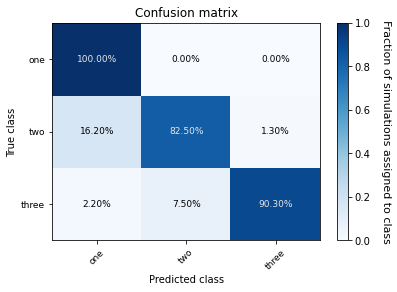

[[439 493  68]
 [  3 864 133]
 [  0 181 819]]


/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


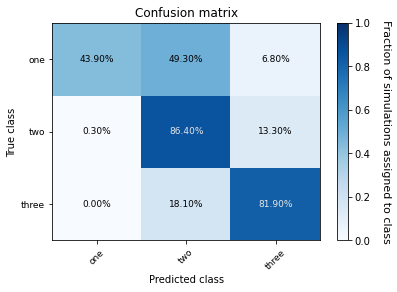

[[939  35  26]
 [101 486 413]
 [ 80 449 471]]


/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


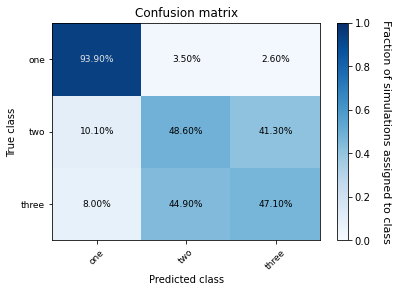

[[995   1   4]
 [178 792  30]
 [ 34  69 897]]


/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


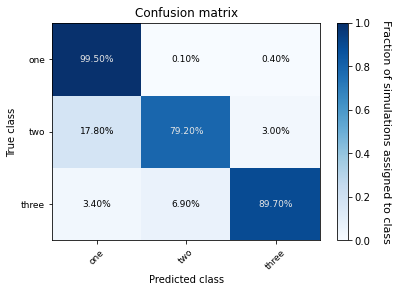

[[1000    0    0]
 [ 168  811   21]
 [  56   70  874]]


/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


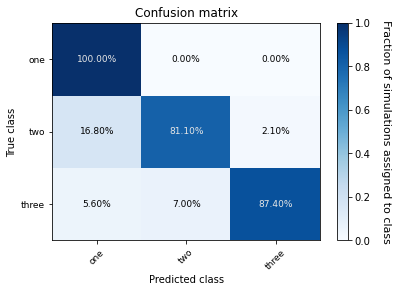

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


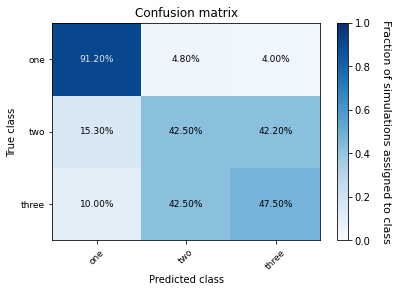

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


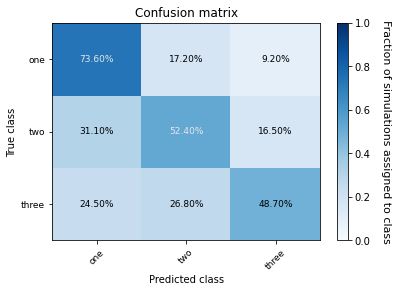

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


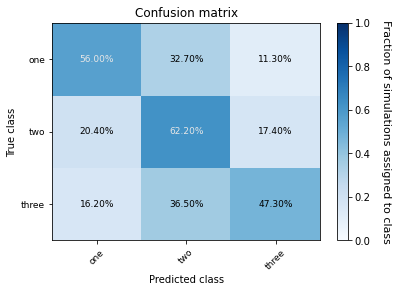

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


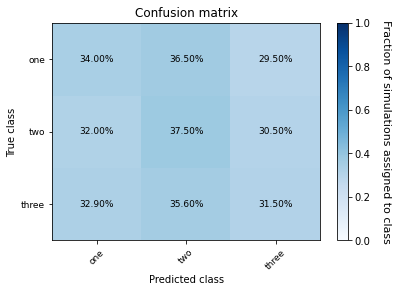

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


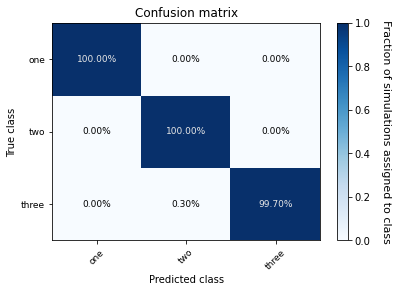

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


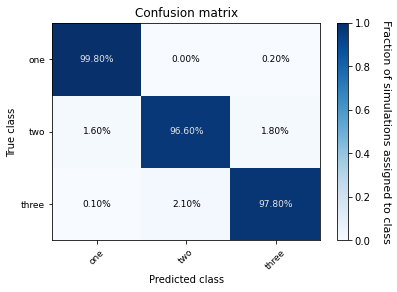

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


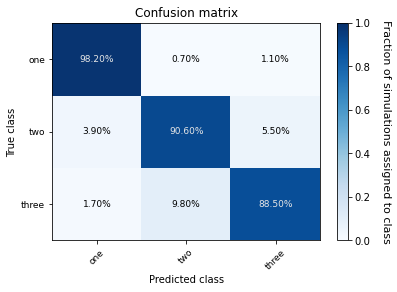

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


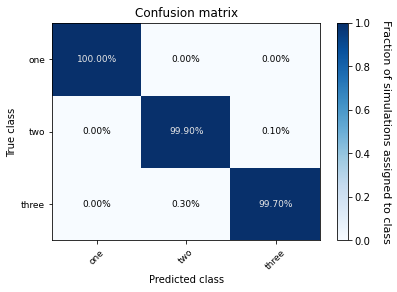

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


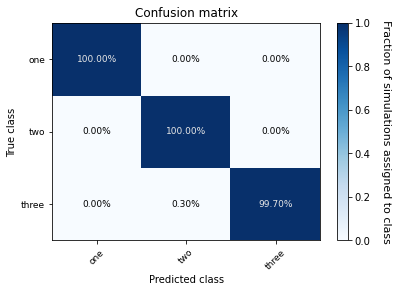

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


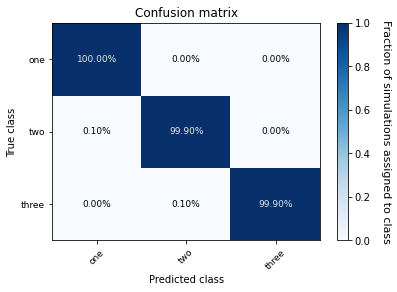

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


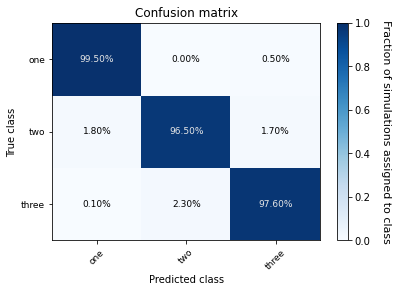

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


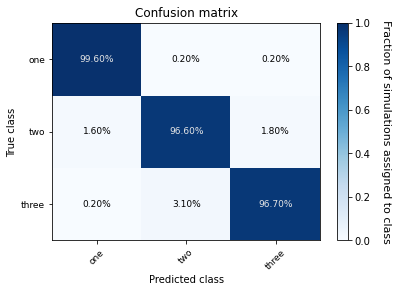

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


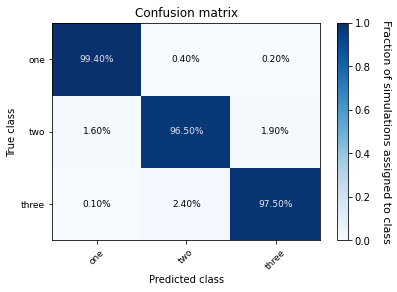

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


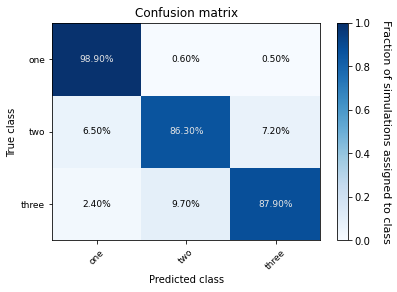

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


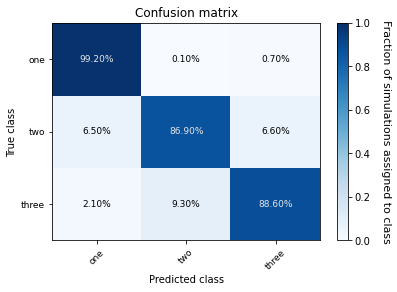

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


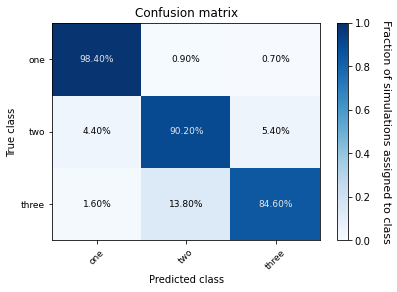

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


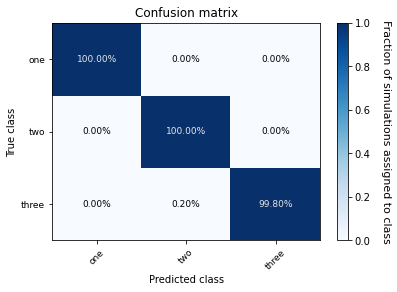

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


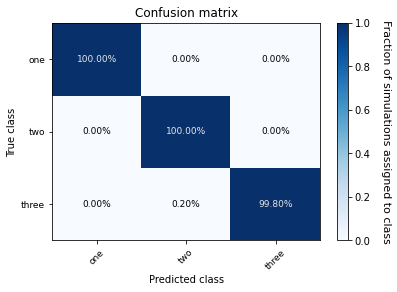

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


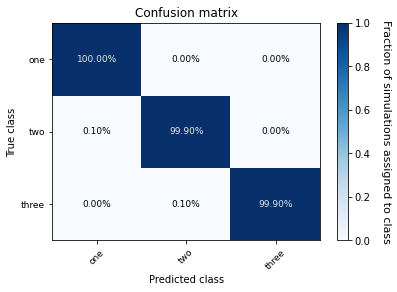

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


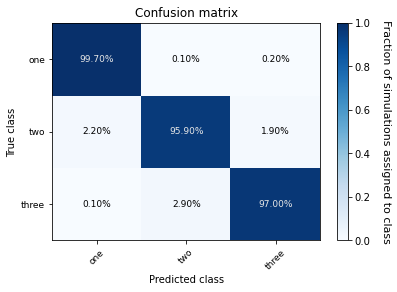

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


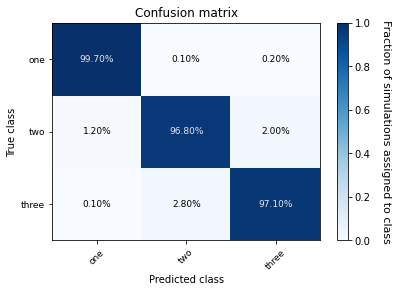

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


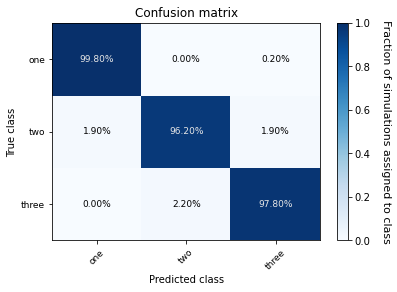

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


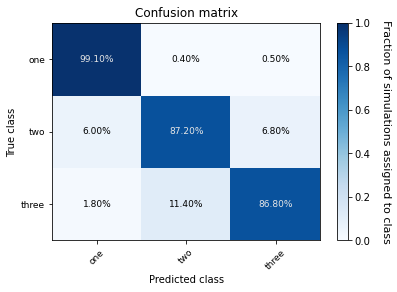

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


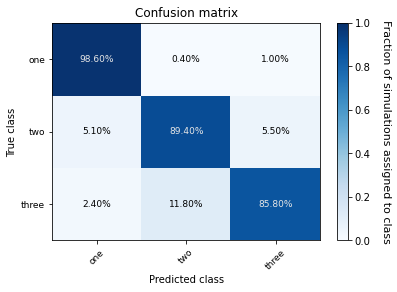

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


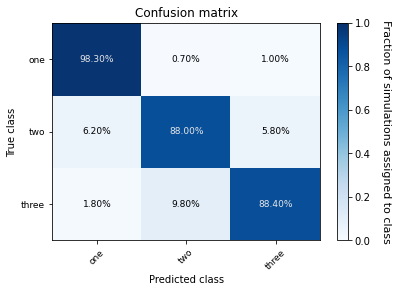

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


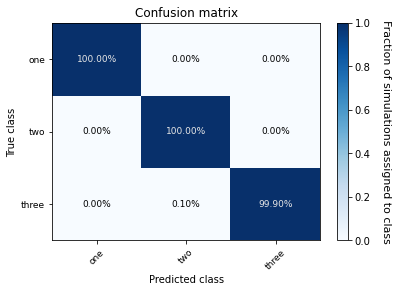

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


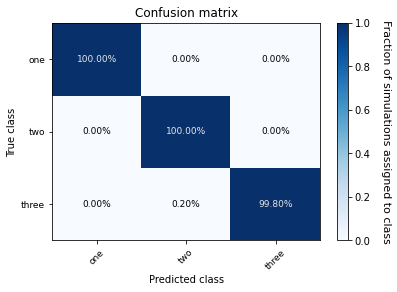

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


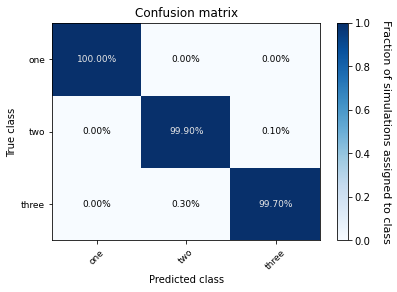

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


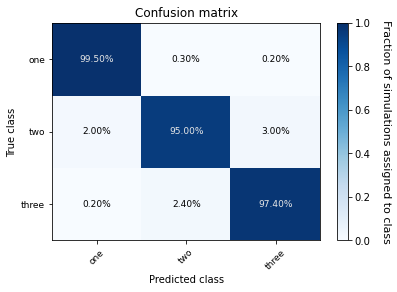

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


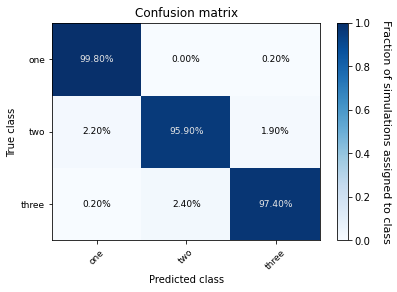

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


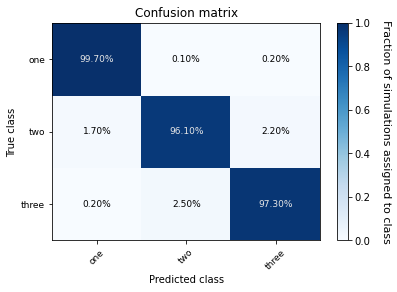

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


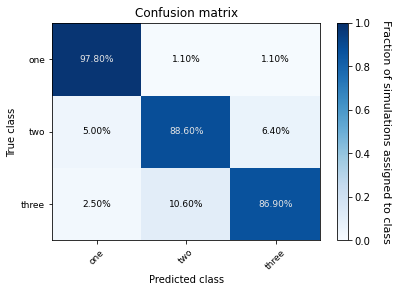

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


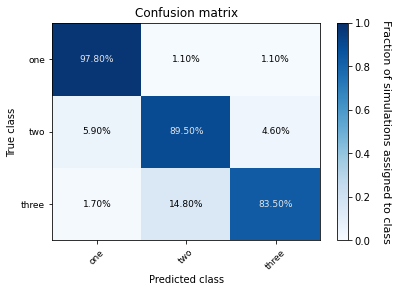

/tmp/ipykernel_3750513/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


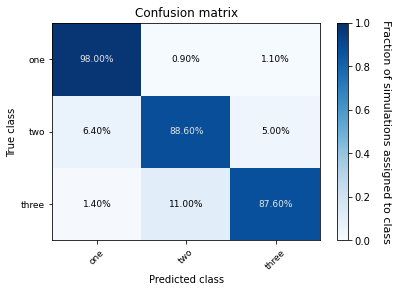

In [7]:
# Now we will plot the confusion matrices for each trained model
#first get the predictions
pred = model1.predict(traits_BM.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

# Print the confusion matrix
print (confusion_matrix(ytest, pred_cat))
#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions for the next dataset
pred = model2.predict(traits_BM50.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# Print the confusion matrix
print (confusion_matrix(ytest, pred_cat))
#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model3.predict(traits_BM10.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# Print the confusion matrix
print (confusion_matrix(ytest, pred_cat))
#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model4.predict(traits_OU.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

# Print the confusion matrix
print (confusion_matrix(ytest, pred_cat))
#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model5.predict(traits_OU50.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model6.predict(traits_OU10.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model7.predict(traits_disc.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model8.predict(traits_disc50.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model9.predict(traits_disc10.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model10.predict(xtest)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model11.predict(xtest[:,0:50,:])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model12.predict(xtest[:,0:20,:])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model13.predict([traits_BM.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model14.predict([traits_BM50.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model15.predict([traits_BM10.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model16.predict([traits_BM.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model17.predict([traits_BM50.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model18.predict([traits_BM10.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model19.predict([traits_BM.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model20.predict([traits_BM50.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model21.predict([traits_BM10.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model22.predict([traits_OU.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model23.predict([traits_OU50.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model24.predict([traits_OU10.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model25.predict([traits_OU.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model26.predict([traits_OU50.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model27.predict([traits_OU10.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model28.predict([traits_OU.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model29.predict([traits_OU50.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model30.predict([traits_OU10.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model31.predict([traits_disc.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model32.predict([traits_disc50.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model33.predict([traits_disc10.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model34.predict([traits_disc.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model35.predict([traits_disc50.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model36.predict([traits_disc10.reshape(3000,-1), xtest[:,0:50,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model37.predict([traits_disc.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model38.predict([traits_disc50.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions
pred = model39.predict([traits_disc10.reshape(3000,-1), xtest[:,0:20,:]])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()